In [1]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import imageio
from sklearn import cluster
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline


[//]: Info
# Yasmeen Khaled		37-6614		yasmeen.abdelmohsen@student.guc.edu.eg
# Michael George		37-3063		michael.khalil@student.guc.edu.eg
# Olfat Mostafa		37-19029	olfat.aaf@student.guc.edu.eg


In [2]:
def read_img(filename, size):
    
    image = plt.imread(filename)
    
    return image

def normalizeImage(image):
    
    if len(image.shape) > 2:
        
        x, y, z = image.shape
        
        image_reshaped = image.reshape(x*y, z)
        
        image_reshaped = np.array(image_reshaped, dtype = np.float)
        
    else:
        
        x, y = image.shape
        
        image_reshaped = image.reshape(x*y, 1)
        
        image_reshaped = np.array(image_reshaped, dtype = np.float)
        
    return image_reshaped

def retrieveImage(image_reshaped, X, Y, mode = 'RGB', vis = False):
    
    if mode == 'RGB':
        
        image_reshaped = (image_reshaped * 255).astype(np.uint8)
        
        retrieveImage = image_reshaped.reshape(X, Y, 3)
        
    elif mode == 'L':
        
        retrieveImage = image_reshaped.reshape(X, Y)
        
    return retrieveImage

def init(img, k):
    
    if len(img.shape) == 1:
        
        means = randint(low = 0, high = 255, size = (k,1))
        
        cov = randint(low = 0, high = 500, size = k)
        
        pis = random(size = k)
        
    else:
        
        z = img.shape[1]
        
        means = randint(low = 0, high = 255, size = (k , z))
        
        pre_cov = randint(low=0, high=k, size=img.shape[0])
        
        cov = np.array([np.cov(img[pre_cov == i].T) for i in range(k)])
        
        pis = random(size = k)
    
    return means, cov, pis

def update_z_score(img, means, cov, pis, k):
    # z_scores: i th pixels, j th class
    # pis * gaussian.pdf
    
    z_scores = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T

    norm = np.sum(z_scores, axis = 1)

    norm = np.reshape(norm, (len(norm), 1))
    
    z_scores = z_scores / norm
    
    return z_scores

def update_pis(z_scores):
    
    pis = np.sum(z_scores, axis = 0) / z_scores.shape[0]
    
    return pis

def update_means(img, z_scores):
    means = []
    
    class_n = z_scores.shape[1]
    
    for j in range(class_n):
        
        weight = z_scores[:, j] / np.sum(z_scores[:, j])
        
        weight = np.reshape(weight, (1, len(weight)))
        
        means_j = weight.dot(img)
        
        means.append(means_j[0])
        
    means = np.array(means)
    
    return means

def update_covariance(img, z_scores, means):
    
    cov = []
    
    class_n = z_scores.shape[1]
    
    for j in range(class_n):
        
        weight = z_scores[:, j] / np.sum(z_scores[:, j])
        
        weight = np.reshape(weight, (1, len(weight)))

        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]

        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        
        cov.append(cov_j)
        
    cov = np.array(cov)
    
    return cov

def update_labels(z_scores):
    
    labels = np.argmax(z_scores, axis = 1)
    
    return labels


def update_likelihood(img, means, cov, pis, k):
    
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    
    log_ll = np.log(np.sum(pdf, axis = 0))
    
    log_ll_sum = np.sum(log_ll)
    
    return log_ll_sum


def EM(img, k, error = 10e-4, iter_n = 5):
    
    cnt = 0
    
    likelihood_arr = []
    
    means_arr = []
    
    means, cov, pis = init(img, k)
    
    #print(means, cov, pis)
    likelihood = 0
    
    new_likelihood = 2
    
    means_arr.append(means)
    
    z_scores = update_z_score(img, means, cov, pis, k)
    
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        
        cnt += 1
        
        likelihood = new_likelihood
        
        # M Step
        labels = update_labels(z_scores)
        
        # E step
        z_scores = update_z_score(img, means, cov, pis, k)
        
        means = update_means(img, z_scores)
        
        cov = update_covariance(img, z_scores, means)
        
        pis = update_pis(z_scores)
        
        new_likelihood = update_likelihood(img, means, cov, pis, k)
        
        likelihood_arr.append(new_likelihood)
        
        print("iter: %s" % (cnt))
        
        print("likelihood = {}".format(new_likelihood))
        
        means_arr.append(means)
        
    likelihood_arr = np.array(likelihood_arr)
    
    print('Converge at iteration {}'.format(cnt + 1))
    
    return labels, means, cov, pis, likelihood_arr, means_arr


In [3]:
def get_pdf(y, means, cov, pis, k):
    
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j]) for j in range(k)])
    
    pdf = np.sum(pdf_arr)
    
    return pdf

In [4]:
FILENAME_LIST = ['./res/star.jpg','./res/starg.jpg']

uint8
uint8


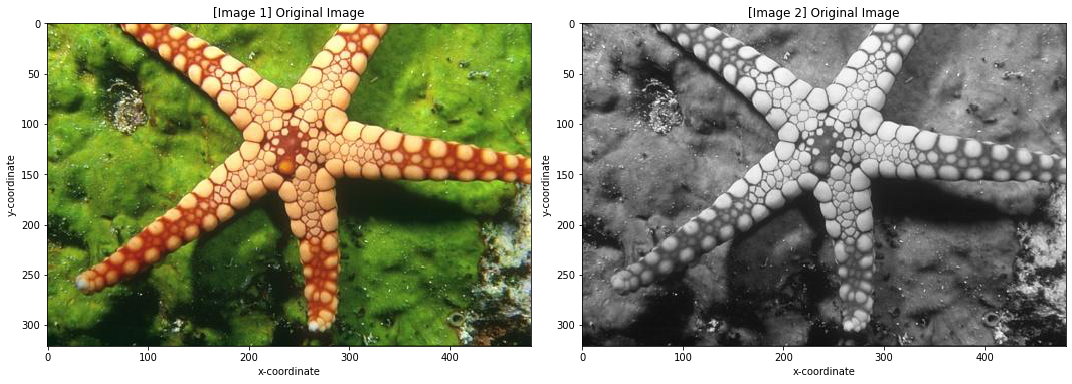

In [5]:
# Visualize demo images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,15))
ax_list = [ax1, ax2]
rgb_img_list = []
dim_img_list = []
modes = ['RGB','L']
i = 1
# spec= loadmat('res/SalinasA_Q3.mat')
# groundtruth=loadmat('res/SalinasA_GT3.mat')
# groundtruthdata=groundtruth['Q3_GT']
# img = spec['Q3'][2]
for filename, ax in zip(FILENAME_LIST, ax_list):
    img = read_img(filename = filename ,size = (1, 1))
    print (img.dtype)

    if(len(img.shape) > 2):
        x, y, z = img.shape
        dim_img_list.append((x,y,z))
    else:
        x, y = img.shape
        dim_img_list.append((x,y))

    rgb_img_list.append(img)
    ax.imshow(img,cmap="gray")
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

plt.tight_layout()
fig.savefig('orig_images.pdf')

In [6]:
img_list = [normalizeImage(image) for image in rgb_img_list]

In [7]:
# Init container
rand_likelihood_arr_list = []
rand_means_arr_list = []
rand_cov_arr_list = []
rand_pis_arr_list = []
rand_em_img_list = []
rand_means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM(img, 2, error = 0.001,iter_n=20)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    rand_likelihood_arr_list.append(likelihood_arr)
    rand_means_arr_list.append(means_arr)
    rand_cov_arr_list.append(cov)
    rand_pis_arr_list.append(pis)
    rand_em_img_list.append(recover_img)
    rand_means_list.append(means)

iter: 1
likelihood = -2331343.1164350044
iter: 2
likelihood = -2329078.1890441207
iter: 3
likelihood = -2325579.6703098696
iter: 4
likelihood = -2318956.218175421
iter: 5
likelihood = -2310396.62891352
iter: 6
likelihood = -2300560.952766094
iter: 7
likelihood = -2288642.1815008926
iter: 8
likelihood = -2274300.8253162783
iter: 9
likelihood = -2258620.389051455
iter: 10
likelihood = -2244193.0438479837
iter: 11
likelihood = -2231747.5331784906
iter: 12
likelihood = -2215152.0193716744
iter: 13
likelihood = -2178593.959737822
iter: 14
likelihood = -2137956.969874053
iter: 15
likelihood = -2130948.487189506
iter: 16
likelihood = -2129614.2622849043
iter: 17
likelihood = -2129188.9313036213
iter: 18
likelihood = -2129038.38699006
iter: 19
likelihood = -2128983.009131992
iter: 20
likelihood = -2128962.031959349
Converge at iteration 21
iter: 1
likelihood = -834604.131466009
iter: 2
likelihood = -834595.9329746873
iter: 3
likelihood = -834591.9206524479
iter: 4
likelihood = -834589.86406424

In [8]:
# Store density estimate (i.e pdf)
rand_pdf_arr_list = []
for em_img, means, cov, pis in zip(rand_em_img_list, rand_means_list, rand_cov_arr_list, rand_pis_arr_list):
    rand_pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    rand_pdf_arr_list.append(rand_pdf_arr)

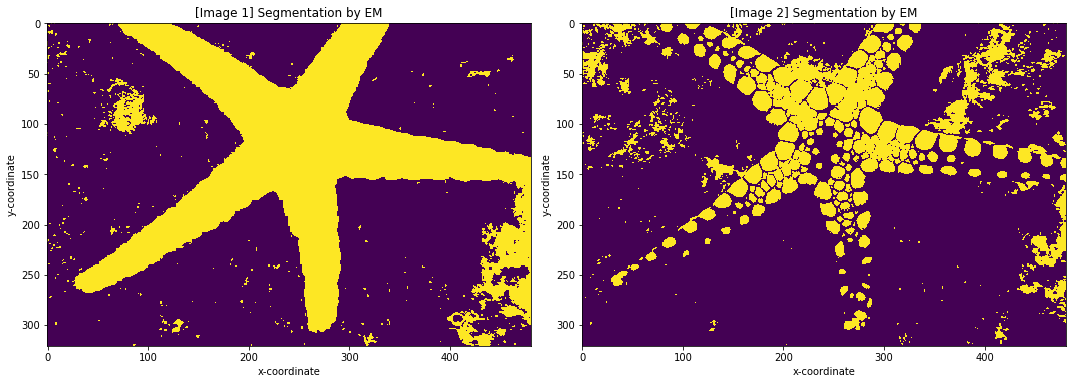

In [9]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,15))
ax_list = [ax1, ax2]
i = 1
for rand_em_img, ax in zip(rand_em_img_list, ax_list):
    ax.imshow(rand_em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;
plt.tight_layout();
fig.savefig('em.pdf')